In [1]:
import sys, os
from dataclasses import dataclass
os.environ['OMP_NUM_THREADS'] = '8'
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import scipy

import euclidemu2
import cosmolike_des_y3_interface as ci
from getdist import IniFile

import itertools

sys.path.insert(0, os.environ['ROOTDIR']+'/external_modules/code/CAMB/build/lib.linux-x86_64-'+os.environ['PYTHON_VERSION'])
import camb
from camb import model
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

# Plot style
rcParams['mathtext.fontset'] = "stix"
rcParams['font.family'] = "STIXGeneral"

Using CAMB 1.6.0 installed at /home/joao/cosmo/cocoa/Cocoa/.local/lib/python3.10/site-packages/camb


In [58]:
@dataclass
class CosmoParams:
    As_1e9: float = 2.1
    ns: float = 0.96
    H0: float = 67
    omegab: float = 0.049
    omegam: float = 0.319
    mnu: float = 0.06    
    w0pwa: float = -0.8
    w: float = -0.8
    cs2_0: float = 1.0

@dataclass
class NuisanceParams:
    DES_DZ_S1: float = 0.0414632
    DES_DZ_S2: float = 0.00147332
    DES_DZ_S3: float = 0.0237035
    DES_DZ_S4: float = -0.0773436
    DES_M1: float = 0.0191832
    DES_M2: float = -0.0431752
    DES_M3: float = -0.034961
    DES_M4: float = -0.0158096
    DES_A1_1: float = 0.606102
    DES_A1_2: float = -1.51541
    DES_A2_1: float = -1.7938938475734911 
    DES_A2_2: float = -1.5448080290038528
    DES_BTA_1: float = 0.8154011496506723

@dataclass
class Settings:
    path: str = "../../external_modules/data/des_y3"
    data_file: str = "des_y3_real.dataset"
    CLprobe: str = "xi"
    CAMBAccuracyBoost: float = 1.1
    AccuracyBoost: float = 1.0
    CLAccuracyBoost: float = 1.0
    CLIntegrationAccuracy: int = 1
    non_linear_emul: int = 2
    IA_model: int = 1
    IA_redshift_evolution: int = 3
    ntheta: int = 20 
    theta_min_arcmin: float = 2.5 
    theta_max_arcmin: float = 250     

In [59]:
def cosmolike_init(settings):
    # Init Cosmolike
    ini = IniFile(os.path.normpath(os.path.join(settings.path, settings.data_file)))

    lens_file = ini.relativeFileName('nz_lens_file')
    source_file = ini.relativeFileName('nz_source_file')
    lens_ntomo = ini.int("lens_ntomo")
    source_ntomo = ini.int("source_ntomo")

    ci.initial_setup()

    ci.init_accuracy_boost(1.0, int(1))

    ci.init_cosmo_runmode(is_linear = False)

    ci.init_redshift_distributions_from_files(
        lens_multihisto_file=lens_file,
        lens_ntomo=int(lens_ntomo), 
        source_multihisto_file=source_file,
        source_ntomo=int(source_ntomo))

    ci.init_IA(ia_model=int(settings.IA_model), 
    ia_redshift_evolution=int(settings.IA_redshift_evolution))

In [60]:
settings = Settings()
cosmolike_init(settings)

In [61]:
def get_camb_cosmology(c: CosmoParams, s: Settings):
    As = c.As_1e9*1e-9
    wa = c.w0pwa - c.w
    h = c.H0/100
    omegabh2 = c.omegab*h**2
    omegach2 = (c.omegam-c.omegab)*h**2-(c.mnu*(3.046/3)**0.75)/94.0708
    omegamh2 = c.omegam*h**2

    CAMBAccuracyBoost = s.CAMBAccuracyBoost*s.AccuracyBoost
    kmax = 10
    kmax = max(kmax/2.0, kmax*(1.0 + 3*(s.AccuracyBoost-1)))
    k_per_logint = 20
    k_per_logint = max(k_per_logint/2.0, int(k_per_logint) + int(3*(s.AccuracyBoost-1)))
    extrap_kmax = max(2.5e2, 3*kmax) * s.AccuracyBoost

    z_interp_1D = np.concatenate((
                  np.linspace(0, 2.0, 1000),
                  np.linspace(2.0, 10.1, 200),
                  np.linspace(1080, 2000, 20)))
    
    z_interp_2D = np.concatenate((np.linspace(0, 2.0, 130), np.linspace(2.25, 10, 50)))
    log10k_interp_2D = np.linspace(-4.2, 2.0, 1400)

    pars = camb.set_params(H0=c.H0, 
                           ombh2=omegabh2, 
                           omch2=omegach2, 
                           mnu=c.mnu, 
                           omk=0, 
                           tau=0.06,  
                           As=As, 
                           ns=c.ns, 
                           w0=c.w,
                           wa=wa,
                           dark_energy_model="fluid",
                           cs2_type=camb.dark_energy.Cs2_Constant,
                           cs2_0=c.cs2_0,
                           halofit_version='takahashi', 
                           lmax=10,
                           AccuracyBoost=CAMBAccuracyBoost,
                           lens_potential_accuracy=1.0,
                           num_massive_neutrinos=1,
                           nnu=3.046,
                           accurate_massive_neutrino_transfers=False,
                           k_per_logint=k_per_logint,
                           kmax=kmax)
    
    pars.NonLinear = model.NonLinear_both
    pars.set_matter_power(redshifts=z_interp_2D, kmax=kmax, silent=True)
    
    results = camb.get_results(pars)
    
    PKL  = results.get_matter_power_interpolator(var1="delta_tot", var2="delta_tot", nonlinear=False, 
                                                 extrap_kmax=extrap_kmax, hubble_units=False, k_hunit=False)
    
    PKNL = results.get_matter_power_interpolator(var1="delta_tot", var2="delta_tot",  nonlinear=True, 
                                                 extrap_kmax=extrap_kmax, hubble_units=False, k_hunit=False)
    
    lnPL = np.empty(len(log10k_interp_2D)*len(z_interp_2D))
    for i in range(len(z_interp_2D)):
        lnPL[i::len(z_interp_2D)] = np.log(PKL.P(z_interp_2D[i], np.power(10.0,log10k_interp_2D)))
    lnPL  += np.log(((c.H0/100.)**3)) 
    
    lnPNL  = np.empty(len(log10k_interp_2D)*len(z_interp_2D))
    if s.non_linear_emul == 1:
        params = {'Omm': c.omegam, 
                  'As' : As, 
                  'Omb': c.omegab,
                  'ns' : c.ns, 
                  'h'  : h, 
                  'mnu': c.mnu,  
                  'w'  : c.w, 
                  'wa' : wa}
        
        kbt, bt = euclidemu2.get_boost(params, 
                                       z_interp_2D, 
                                       np.power(10.0, np.linspace( -2.0589, 0.973, len(log10k_interp_2D))))
        log10k_interp_2D = log10k_interp_2D - np.log10(h)
        
        for i in range(len(z_interp_2D)):
            lnbt = scipy.interpolate.interp1d(np.log10(kbt), np.log(bt[i]), kind='linear', 
                                              fill_value='extrapolate', 
                                              assume_sorted = True)(log10k_interp_2D)
            lnbt[np.power(10,log10k_interp_2D) < 8.73e-3] = 0.0
            lnPNL[i::len(z_interp_2D)] = lnPL[i::len(z_interp_2D)] + lnbt
    elif s.non_linear_emul == 2:
        for i in range(len(z_interp_2D)):
            lnPNL[i::len(z_interp_2D)] = np.log(PKNL.P(z_interp_2D[i], np.power(10.0, log10k_interp_2D)))            
        log10k_interp_2D = log10k_interp_2D - np.log10(h)
        lnPNL += np.log(h**3)

    G_growth = np.sqrt(PKL.P(z_interp_2D,0.0005)/PKL.P(0,0.0005))
    G_growth = G_growth*(1 + z_interp_2D)
    G_growth = G_growth/G_growth[len(G_growth)-1]
    
    chi = results.comoving_radial_distance(z_interp_1D, tol=1e-4) * h

    return (log10k_interp_2D, z_interp_2D, lnPL, lnPNL, G_growth, z_interp_1D, chi)

In [62]:
def C_ss_tomo_limber(ell, 
                     c: CosmoParams,
                     n: NuisanceParams,
                     s: Settings,
                     baryon_sims = None):

    log10k_interp_2D, z_interp_2D, lnPL, lnPNL, G_growth, z_interp_1D, chi = get_camb_cosmology(c, s)

    CLAccuracyBoost = s.CLAccuracyBoost * s.AccuracyBoost
    CLSamplingBoost = s.CLAccuracyBoost * s.AccuracyBoost
    CLIntegrationAccuracy = max(0, s.CLIntegrationAccuracy + 3*(s.AccuracyBoost-1.0))
    ci.init_accuracy_boost(1.0, CLSamplingBoost, int(CLIntegrationAccuracy))

    ci.set_cosmology(omegam=c.omegam, 
                     H0=c.H0, 
                     log10k_2D = log10k_interp_2D, 
                     z_2D=z_interp_2D, 
                     lnP_linear=lnPL,
                     lnP_nonlinear=lnPNL,
                     G=G_growth,
                     z_1D=z_interp_1D,
                     chi=chi)
    ci.set_nuisance_shear_calib(M=[n.DES_M1, n.DES_M2, n.DES_M3, n.DES_M4])
    ci.set_nuisance_shear_photoz(bias=[n.DES_DZ_S1, n.DES_DZ_S2, n.DES_DZ_S3, n.DES_DZ_S4])
    ci.set_nuisance_ia(A1=[n.DES_A1_1, n.DES_A1_2, 0, 0], A2=[n.DES_A2_1, n.DES_A2_2, 0, 0], B_TA=[n.DES_BTA_1, 0, 0, 0])

    if baryon_sims is None:
        ci.reset_bary_struct()
    else:
        ci.init_baryons_contamination(sim = baryon_sims)
        
    return ci.C_ss_tomo_limber(l = ell)

In [63]:
def xi(c: CosmoParams,
       n: NuisanceParams,
       s: Settings,
       baryon_sims=None):

    log10k_interp_2D, z_interp_2D, lnPL, lnPNL, G_growth, z_interp_1D, chi = get_camb_cosmology(c, s)

    CLAccuracyBoost = s.CLAccuracyBoost * s.AccuracyBoost
    CLSamplingBoost = s.CLAccuracyBoost * s.AccuracyBoost
    CLIntegrationAccuracy = max(0, s.CLIntegrationAccuracy + 5*(s.AccuracyBoost-1.0))
    ci.init_accuracy_boost(CLAccuracyBoost, int(CLIntegrationAccuracy))
    
    ci.init_binning(int(s.ntheta), s.theta_min_arcmin, s.theta_max_arcmin)
    
    ci.set_cosmology(omegam=c.omegam, 
                     H0=c.H0, 
                     log10k_2D = log10k_interp_2D, 
                     z_2D=z_interp_2D, 
                     lnP_linear=lnPL,
                     lnP_nonlinear=lnPNL,
                     G=G_growth,
                     z_1D=z_interp_1D,
                     chi=chi)
    ci.set_nuisance_shear_calib(M=[n.DES_M1, n.DES_M2, n.DES_M3, n.DES_M4])
    ci.set_nuisance_shear_photoz(bias=[n.DES_DZ_S1, n.DES_DZ_S2, n.DES_DZ_S3, n.DES_DZ_S4])
    ci.set_nuisance_ia(A1=[n.DES_A1_1, n.DES_A1_2, 0, 0], A2=[n.DES_A2_1, n.DES_A2_2, 0, 0], B_TA=[n.DES_BTA_1, 0, 0, 0])

    if baryon_sims is None:
        ci.reset_bary_struct()
    else:
        ci.init_baryons_contamination(sim = baryon_sims)
        
    xip, xim = ci.xi_pm_tomo()    
    return (ci.get_binning_real_space(), xip, xim)

In [78]:
c = CosmoParams()
n = NuisanceParams()
results = []
cs2_values = [1, 1e-1, 1e-2, 1e-3]
labels = ["$c_s^2 = 1$", "$c_s^2 = 0.1$", "$c_s^2 = 0.01$", "$c_s^2 = 0.001$"]
for cs2_value in cs2_values:
    c.cs2_0 = cs2_value
    theta, xip, xim = xi(c, n, settings)
    results.append((xip, xim))

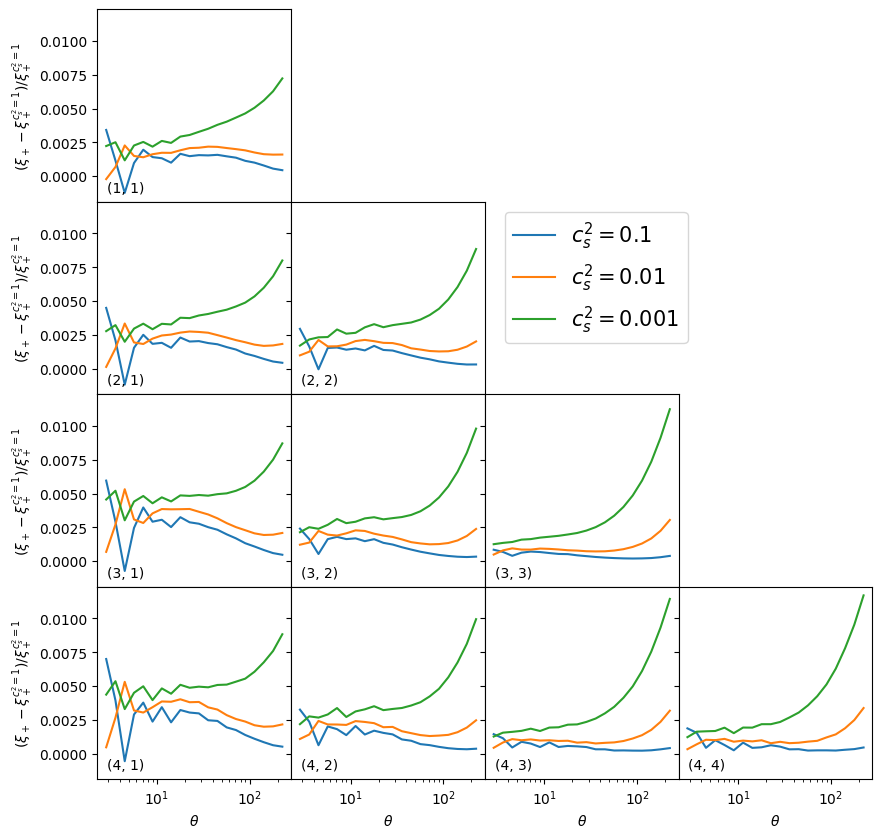

In [79]:
# Plotting xip
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10, 10), gridspec_kw={'wspace': 0, 'hspace': 0})
for i in range(4):
    for j in range(4):
        ax = axs[i, j]
        if i < j:
            ax.remove()
            continue
        for result, cs2_value, label in zip(results, cs2_values, labels):
            if cs2_value == 1: continue
            xip, xim = result
            xip_1, xim_1 = results[0]
            ax.semilogx(theta, (xip[:, i, j]-xip_1[:, i, j])/xip_1[:, i, j], label=label)
        ax.text(0.05, 0.05, f"({i+1}, {j+1})", transform=ax.transAxes)
        if i == 3: ax.set_xlabel("$\\theta$")
        if j == 0: ax.set_ylabel("$(\\xi_+ - \\xi_+^{c_s^2 = 1})/\\xi_+^{c_s^2 = 1}$")
plt.legend(bbox_to_anchor=(0.1, 3), fontsize=15)
plt.savefig("plots/cs2_impact_xip.pdf")

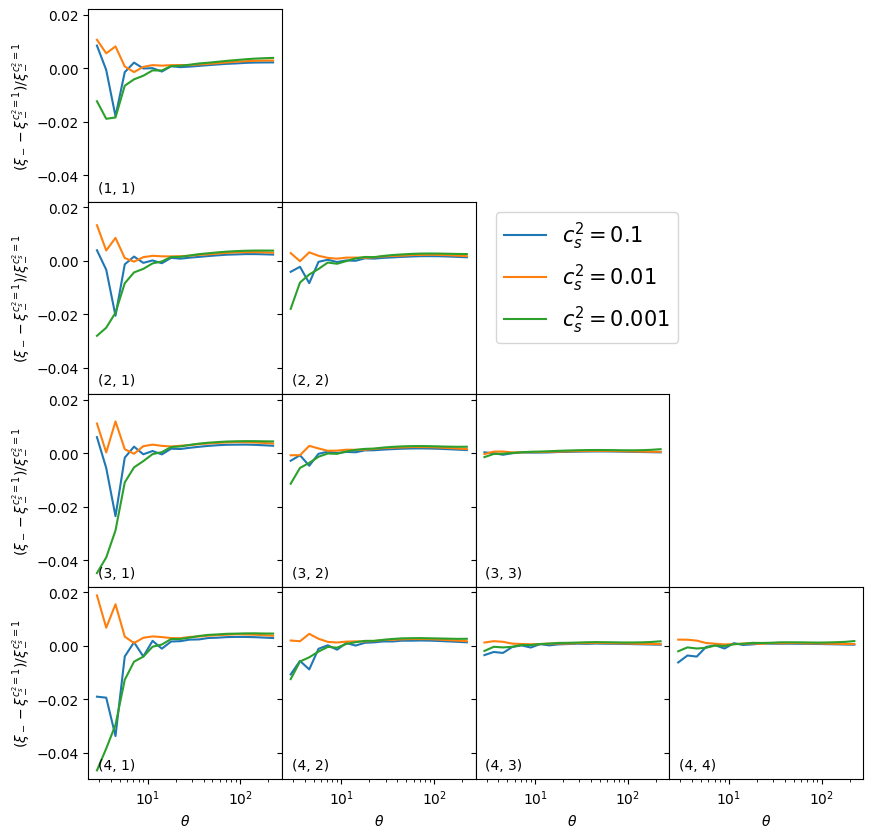

In [80]:
# Plotting xim
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10, 10), gridspec_kw={'wspace': 0, 'hspace': 0})
for i in range(4):
    for j in range(4):
        ax = axs[i, j]
        if i < j:
            ax.remove()
            continue
        for result, cs2_value, label in zip(results, cs2_values, labels):
            if cs2_value == 1: continue
            xip, xim = result
            xip_1, xim_1 = results[0]
            ax.semilogx(theta, (xim[:, i, j]-xim_1[:, i, j])/xim_1[:, i, j], label=label)
        ax.text(0.05, 0.05, f"({i+1}, {j+1})", transform=ax.transAxes)
        if i == 3: ax.set_xlabel("$\\theta$")
        if j == 0: ax.set_ylabel("$(\\xi_- - \\xi_-^{c_s^2 = 1})/\\xi_-^{c_s^2 = 1}$")
plt.legend(bbox_to_anchor=(0.1, 3), fontsize=15)
plt.savefig("plots/cs2_impact_xim.pdf")